# TEXT MINING
# BANK REVIEW/ COMPLAINT's ANALYSIS

In [489]:
#import required packages
#basics
import pandas as pd     
import numpy as np

#misc
import gc
import time
import warnings

#stats
#from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss

#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
#import matplotlib_venn as venn

#nlp
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords

#import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize

# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   


#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm, decomposition, ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

import  textblob
import xgboost
import copy
#from keras.preprocessing import text, sequence
#from keras import layers, models, optimizers

from textblob import TextBlob
from nltk.stem import PorterStemmer
import nltk
nltk.download('wordnet')
from textblob import Word

# Importing Gensim
import gensim
from gensim import corpora

#settings
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

%matplotlib inline

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anubh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Importing DATA

In [490]:
rev_bank=pd.read_excel('BankReviews.xlsx')
bank=copy.deepcopy(rev_bank)

bank['Reviews'] = bank['Reviews'].apply(lambda x: x.replace('_x000D_', '').replace('\n', ' '))
# data_xls.columns.map(lambda x: x.replace('\r','').replace('\n', ''))

In [491]:
bank.tail()

,Date,Stars,Reviews,BankName
500,2016-02-06,1,I never write reviews but had to this time to...,North American Savings Bank
501,2016-07-25,1,It all started when Bob G ran a credit check ...,North American Savings Bank
502,2017-09-27,1,What a horrible experience. We have excellent...,North American Savings Bank
503,2017-12-24,1,"Rep was extremely professional, friendly, and...",North American Savings Bank
504,2017-03-19,1,I was working with a loan consultant from NASB...,North American Savings Bank


## Basic Exploratory Analysis

In [492]:
bank['Reviews'] = bank['Reviews'].astype(str)
bank['count_sent']=bank["Reviews"].apply(lambda x: len(re.findall("\n",str(x)))+1)

#Word count in each comment:
bank['count_word']=bank["Reviews"].apply(lambda x: len(str(x).split()))

#Unique word count
bank['count_unique_word']=bank["Reviews"].apply(lambda x: len(set(str(x).split())))

#Letter count
bank['count_letters']=bank["Reviews"].apply(lambda x: len(str(x)))

#Word density

bank['word_density'] = bank['count_letters'] / (bank['count_word']+1)

#punctuation count
bank["count_punctuations"] =bank["Reviews"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

#upper case words count
bank["count_words_upper"] = bank["Reviews"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

#upper case words count
bank["count_words_lower"] = bank["Reviews"].apply(lambda x: len([w for w in str(x).split() if w.islower()]))

#title case words count
bank["count_words_title"] = bank["Reviews"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

#Number of stopwords
bank["count_stopwords"] = bank["Reviews"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

#Average length of the words
bank["mean_word_len"] = bank["Reviews"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

#Number of numeric
bank['numeric'] = bank['Reviews'].apply(lambda x :len([x for x in x.split() if x.isdigit()]))

#Number of alphanumeric
bank['alphanumeric'] = bank['Reviews'].apply(lambda x :len([x for x in x.split() if x.isalnum()]))

#Number of alphabetics
bank['alphabetetics'] = bank['Reviews'].apply(lambda x :len([x for x in x.split() if x.isalpha()]))

#Number of spaces
bank['Spaces'] = bank['Reviews'].apply(lambda x :len([x for x in x.split() if x.isspace()]))

# Count the occurences of all words
bank['wordcounts'] = bank['Reviews'].apply(lambda x :dict([ [t, x.split().count(t)] for t in set(x.split()) ]))

pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}

# function to check and get the part of speech tag count of a words in a given sentence
def check_pos_tag(x, flag):
    cnt = 0
    try:
        wiki = textblob.TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_family[flag]:
                cnt += 1
    except:
        pass
    return cnt

bank['noun_count'] = bank['Reviews'].apply(lambda x: check_pos_tag(x, 'noun'))
bank['verb_count'] = bank['Reviews'].apply(lambda x: check_pos_tag(x, 'verb'))
bank['adj_count']  = bank['Reviews'].apply(lambda x: check_pos_tag(x, 'adj'))
bank['adv_count']  = bank['Reviews'].apply(lambda x: check_pos_tag(x, 'adv'))
bank['pron_count'] = bank['Reviews'].apply(lambda x: check_pos_tag(x, 'pron')) 
bank

,Date,Stars,Reviews,BankName,count_sent,count_word,count_unique_word,count_letters,word_density,count_punctuations,...,numeric,alphanumeric,alphabetetics,Spaces,wordcounts,noun_count,verb_count,adj_count,adv_count,pron_count
0,2017-04-10,5,"Great job, Wyndham Capital! Each person was pr...",Wyndham Capital Mortgage,1,19,19,126,6.300000,4,...,0,15,15,0,"{'Capital!': 1, 'our': 1, 'through': 1, 'move'...",8,3,1,1,3
1,2017-02-10,5,Matthew Richardson is professional and helpful...,Wyndham Capital Mortgage,1,25,23,159,6.115385,4,...,0,21,21,0,"{'you': 1, 'correct': 1, 'Matthew': 1, 'the': ...",7,3,4,2,4
2,2017-08-21,5,We had a past experience with Wyndham Mortgage...,Wyndham Capital Mortgage,1,79,64,462,5.775000,8,...,0,73,73,0,"{'Thomka': 1, 'experience': 1, 'Mortgage': 2, ...",24,10,5,8,8
3,2017-12-17,5,We have been dealing with Brad Thomka from the...,Wyndham Capital Mortgage,1,108,78,605,5.550459,9,...,0,101,101,0,"{'Mortgage': 2, 'we': 1, 'found': 1, 'right': ...",30,17,8,7,11
4,2016-05-27,5,I can't express how grateful I am for the supp...,Wyndham Capital Mortgage,1,59,47,341,5.683333,6,...,0,53,53,0,"{'family': 1, 'that': 1, 'demeanor': 1, 'secon...",16,9,4,4,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,2016-02-06,1,I never write reviews but had to this time to...,North American Savings Bank,1,455,233,2456,5.385965,38,...,0,420,420,0,"{'however': 1, 'assessment.': 1, 'in': 3, 'use...",99,102,27,18,61
501,2016-07-25,1,It all started when Bob G ran a credit check ...,North American Savings Bank,1,164,109,826,5.006061,23,...,2,145,143,0,"{'in': 2, 'past': 1, 'coordinate': 1, 'had': 3...",35,34,7,12,22
502,2017-09-27,1,What a horrible experience. We have excellent...,North American Savings Bank,1,135,109,750,5.514706,19,...,1,118,117,0,"{'we': 1, 'in': 1, 'promises': 1, 'then': 1, '...",27,23,14,17,12
503,2017-12-24,1,"Rep was extremely professional, friendly, and...",North American Savings Bank,1,211,147,1098,5.179245,34,...,0,183,182,0,"{'we': 1, 'calls,': 1, 'then': 1, 'you': 2, 'r...",42,41,16,18,31


## Data Processing

### Creating user defined functions for clean the text and pre-process the data

In [493]:
#Abbrevations and Words correction
def clean_text(text):
    text = text.lower()
    text = text.strip()
    text = re.sub(r' +', ' ', text)
    text = re.sub(r"[-()\"#/@;:{}`+=~|.!?,'0-9]", "", text)
#     text = text.apply(lambda x: " ".join(x for x in x.split() if '_xd_' not in x))
    return(text)

In [494]:
bank['Reviews'] = bank['Reviews'].apply(clean_text)

In [495]:
bank['Reviews']

0      great job wyndham capital each person was prof...
1      matthew richardson is professional and helpful...
2      we had a past experience with wyndham mortgage...
3      we have been dealing with brad thomka from the...
4      i cant express how grateful i am for the suppo...
                             ...                        
500    i never write reviews but had to this time to ...
501    it all started when bob g ran a credit check w...
502    what a horrible experience we have excellent c...
503    rep was extremely professional friendly and he...
504    i was working with a loan consultant from nasb...
Name: Reviews, Length: 505, dtype: object

#### Tokenization

In [496]:
bank['Reviews'] = bank['Reviews'].apply(lambda x: nltk.tokenize.word_tokenize(x))

#### Removing Stop words

In [497]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [498]:
def stop_word(x) :
    clean_tokens = []
    for i in x:
        if i not in stopwords.words("english") and i != "":
            clean_tokens.append(i)
    return clean_tokens
bank['Reviews'] = bank['Reviews'].apply(stop_word)

In [499]:
bank['Reviews']

0      [great, job, wyndham, capital, person, profess...
1      [matthew, richardson, professional, helpful, h...
2      [past, experience, wyndham, mortgage, would, w...
3      [dealing, brad, thomka, beginning, started, st...
4      [cant, express, grateful, support, zach, provi...
                             ...                        
500    [never, write, reviews, time, prevent, anyone,...
501    [started, bob, g, ran, credit, check, without,...
502    [horrible, experience, excellent, credit, plen...
503    [rep, extremely, professional, friendly, helpf...
504    [working, loan, consultant, nasb, told, would,...
Name: Reviews, Length: 505, dtype: object

#### POS Tagging

In [500]:
bank['Tag_reviews'] = bank['Reviews'].apply(lambda x: nltk.pos_tag(x))

#### Lemmatization

In [501]:
bank['Reviews'] = bank['Reviews'].apply(lambda x: [Word(word).lemmatize() for word in x])

In [502]:
bank['Reviews'] = bank['Reviews'].apply(lambda x: ' '.join(x))

## Sentiment Analysis

In [503]:
bank['sentiment'] = bank["Reviews"].apply(lambda x: TextBlob(x).sentiment.polarity )

In [504]:
bank.head()

,Date,Stars,Reviews,BankName,count_sent,count_word,count_unique_word,count_letters,word_density,count_punctuations,...,alphabetetics,Spaces,wordcounts,noun_count,verb_count,adj_count,adv_count,pron_count,Tag_reviews,sentiment
0,2017-04-10,5,great job wyndham capital person professional ...,Wyndham Capital Mortgage,1,19,19,126,6.300000,4,...,15,0,"{'Capital!': 1, 'our': 1, 'through': 1, 'move'...",8,3,1,1,3,"[(great, JJ), (job, NN), (wyndham, JJ), (capit...",0.433333
1,2017-02-10,5,matthew richardson professional helpful helped...,Wyndham Capital Mortgage,1,25,23,159,6.115385,4,...,21,0,"{'you': 1, 'correct': 1, 'Matthew': 1, 'the': ...",7,3,4,2,4,"[(matthew, NN), (richardson, NN), (professiona...",0.550000
2,2017-08-21,5,past experience wyndham mortgage would without...,Wyndham Capital Mortgage,1,79,64,462,5.775000,8,...,73,0,"{'Thomka': 1, 'experience': 1, 'Mortgage': 2, ...",24,10,5,8,8,"[(past, JJ), (experience, NN), (wyndham, NN), ...",-0.033869
3,2017-12-17,5,dealing brad thomka beginning started stressfu...,Wyndham Capital Mortgage,1,108,78,605,5.550459,9,...,101,0,"{'Mortgage': 2, 'we': 1, 'found': 1, 'right': ...",30,17,8,7,11,"[(dealing, VBG), (brad, NN), (thomka, NN), (be...",0.086561
4,2016-05-27,5,cant express grateful support zach provided fa...,Wyndham Capital Mortgage,1,59,47,341,5.683333,6,...,53,0,"{'family': 1, 'that': 1, 'demeanor': 1, 'secon...",16,9,4,4,8,"[(cant, NN), (express, NN), (grateful, JJ), (s...",0.086667


In [505]:
bank['sentiment_cat'] = np.where(bank.sentiment>0.1,'Positive', 'Negative')

In [506]:
bank.sentiment_cat.value_counts()

Positive    382
Negative    123
Name: sentiment_cat, dtype: int64

In [507]:
bank.Stars.value_counts()

5    410
1     95
Name: Stars, dtype: int64

In [508]:
pd.crosstab(bank.sentiment_cat, bank.Stars)

Stars,1,5
sentiment_cat,,
Negative,70,53
Positive,25,357


### Split the data into train & Test

In [509]:
# define X and y
X = bank.Reviews
y = bank.Stars
# split the new DataFrame into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(378,)
(127,)
(378,)
(127,)


### Vectorization

In [510]:
#Train
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}', 
                             ngram_range=(1, 1 ), 
                             min_df=5, 
                             encoding='latin-1' ,
                             max_features=800)
xtrain_count = count_vect.fit_transform(X_train)


### View the document term metrics

In [511]:
dtm=xtrain_count.toarray() # dtm-> document term matrix

In [512]:
dtm

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [513]:
count_vect.get_feature_names()

['aaron',
 'able',
 'absolutely',
 'accept',
 'accommodating',
 'account',
 'accurate',
 'across',
 'actual',
 'adam',
 'additional',
 'advice',
 'agent',
 'agreed',
 'alex',
 'almost',
 'along',
 'already',
 'also',
 'always',
 'amazing',
 'american',
 'amount',
 'another',
 'answer',
 'answered',
 'answering',
 'anyone',
 'anything',
 'application',
 'apply',
 'appraisal',
 'appraiser',
 'appreciate',
 'appreciated',
 'approved',
 'around',
 'ask',
 'asked',
 'asking',
 'aspect',
 'attention',
 'available',
 'away',
 'awesome',
 'back',
 'bad',
 'balance',
 'bank',
 'barrett',
 'based',
 'became',
 'beginning',
 'beneficial',
 'best',
 'better',
 'beyond',
 'big',
 'bob',
 'brent',
 'broker',
 'business',
 'buy',
 'buyer',
 'buying',
 'ca',
 'call',
 'called',
 'calling',
 'calm',
 'came',
 'cant',
 'capital',
 'care',
 'causing',
 'certainly',
 'change',
 'changed',
 'check',
 'chose',
 'chris',
 'circumstance',
 'clear',
 'client',
 'close',
 'closed',
 'closing',
 'come',
 'comfor

In [514]:
dtm1=pd.DataFrame(dtm)

In [515]:
dtm1.columns=count_vect.get_feature_names()

In [516]:
dtm1.head()

,aaron,able,absolutely,accept,accommodating,account,accurate,across,actual,adam,...,work,worked,working,would,wouldnt,writing,wrong,wyndham,year,yet
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,1,2,0,0,0,0,0,0,0,0


In [517]:
word_freq = pd.DataFrame(dtm1.apply(sum), columns=['freq'])
word_freq.sort_values('freq', ascending=False, inplace=True)
word_freq = word_freq.head(20)
word_freq

,freq
loan,240
process,178
would,166
time,154
read,140
u,138
home,134
recommend,115
work,113
great,109


<AxesSubplot:>

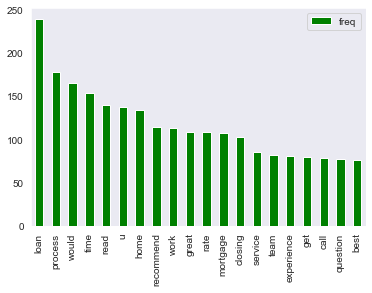

In [518]:
word_freq.plot(kind='bar', color='Green')

#### Generating word clouds using word frequencies (dictionary)

In [519]:
word_freq_dictionary = dict(dtm1.apply(sum))

In [520]:
from wordcloud import WordCloud ,STOPWORDS
wordcloud = WordCloud(background_color='white', stopwords=stopwords.words("english"))

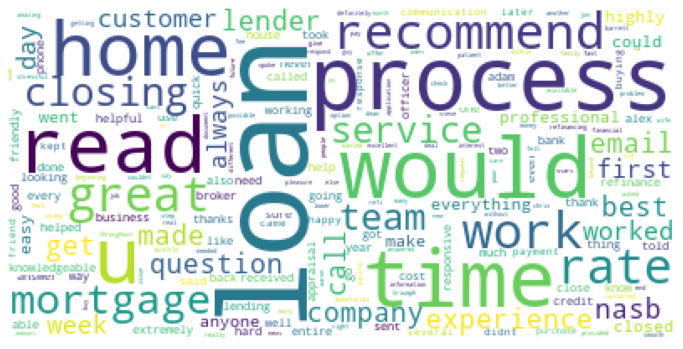

In [521]:
wordcloud = wordcloud.generate_from_frequencies(word_freq_dictionary)

fig = plt.figure(1, figsize=(12, 12))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

### Vectorization (count, tfidf) for both train & test

In [522]:
#Train
count_vect = CountVectorizer(analyzer='word', 
                             token_pattern=r'\w{1,}', 
                             ngram_range=(1, 1 ), 
                             min_df=5, 
                             lowercase = True,
                             encoding='latin-1' , 
                             max_features=1000)
X_train_count = count_vect.fit_transform(X_train)

tfidf_vect = TfidfVectorizer(analyzer='word', 
                             token_pattern=r'\w{1,}', 
                             ngram_range=(1, 1 ), 
                             min_df=5, 
                             encoding='latin-1' , 
                             lowercase = True,
                             max_features=1000)
X_train_tfidf = tfidf_vect.fit_transform(X_train)

#Test
X_test_count = count_vect.transform(X_test)
X_test_tfidf = tfidf_vect.transform(X_test)


In [523]:
dtm_count=pd.DataFrame(X_train_count.toarray(), columns=count_vect.get_feature_names())
dtm_tfidf=pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf_vect.get_feature_names())

### Topic Modeling

### Topic Modeling using gensim (Latent Dirichlet allocation)

In [524]:
X_train_tokens = [doc.split() for doc in X_train]  

In [525]:
dictionary = corpora.Dictionary(X_train_tokens)
print(dictionary)

Dictionary(2174 unique tokens: ['accept', 'agreed', 'already', 'also', 'asking']...)


In [526]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in X_train_tokens]

In [527]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

In [528]:
# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=3, id2word = dictionary, passes=1)

In [529]:
ldamodel.print_topics()

[(0,
  '0.013*"would" + 0.011*"work" + 0.011*"time" + 0.011*"loan" + 0.010*"home" + 0.009*"process" + 0.009*"read" + 0.007*"great" + 0.007*"lender" + 0.007*"rate"'),
 (1,
  '0.016*"loan" + 0.012*"process" + 0.011*"would" + 0.010*"u" + 0.009*"read" + 0.009*"recommend" + 0.009*"home" + 0.008*"mortgage" + 0.008*"team" + 0.007*"time"'),
 (2,
  '0.017*"loan" + 0.011*"process" + 0.011*"time" + 0.010*"closing" + 0.009*"u" + 0.008*"read" + 0.007*"mortgage" + 0.007*"rate" + 0.007*"great" + 0.006*"would"')]

In [530]:
print(ldamodel.print_topics(num_topics=3, num_words=5))

[(0, '0.013*"would" + 0.011*"work" + 0.011*"time" + 0.011*"loan" + 0.010*"home"'), (1, '0.016*"loan" + 0.012*"process" + 0.011*"would" + 0.010*"u" + 0.009*"read"'), (2, '0.017*"loan" + 0.011*"process" + 0.011*"time" + 0.010*"closing" + 0.009*"u"')]


In [531]:
# printing the topic associaltions with the documents
count = 0
for i in ldamodel[doc_term_matrix]:
    print("doc : ",count,i)
    count += 1

doc :  0 [(2, 0.99000335)]
doc :  1 [(0, 0.024923082), (1, 0.51496255), (2, 0.46011436)]
doc :  2 [(0, 0.017765459), (1, 0.9643008), (2, 0.017933765)]
doc :  3 [(2, 0.9900852)]
doc :  4 [(0, 0.014055102), (1, 0.97242785), (2, 0.013517043)]
doc :  5 [(2, 0.9900466)]
doc :  6 [(0, 0.0142128905), (1, 0.014969531), (2, 0.97081757)]
doc :  7 [(1, 0.8645205), (2, 0.12898575)]
doc :  8 [(0, 0.011017026), (1, 0.97798705), (2, 0.010995943)]
doc :  9 [(1, 0.9821219)]
doc :  10 [(0, 0.048074275), (1, 0.9058096), (2, 0.04611613)]
doc :  11 [(0, 0.040253792), (1, 0.038495798), (2, 0.92125046)]
doc :  12 [(0, 0.94128287), (1, 0.02995026), (2, 0.028766904)]
doc :  13 [(0, 0.4404137), (2, 0.5552107)]
doc :  14 [(0, 0.01588412), (1, 0.9693821), (2, 0.014733752)]
doc :  15 [(1, 0.98568505)]
doc :  16 [(0, 0.23359433), (1, 0.7562069), (2, 0.010198712)]
doc :  17 [(0, 0.038061656), (1, 0.04111326), (2, 0.92082506)]
doc :  18 [(0, 0.9428346), (1, 0.028539298), (2, 0.028626097)]
doc :  19 [(1, 0.9879318)]
d

doc :  164 [(0, 0.99549335)]
doc :  165 [(1, 0.9911878)]
doc :  166 [(0, 0.9802718), (2, 0.01074708)]
doc :  167 [(0, 0.982847)]
doc :  168 [(1, 0.18028712), (2, 0.8098566)]
doc :  169 [(0, 0.01633222), (1, 0.96778184), (2, 0.015885914)]
doc :  170 [(0, 0.821032), (1, 0.089674674), (2, 0.08929332)]
doc :  171 [(0, 0.0430742), (1, 0.93420774), (2, 0.022718083)]
doc :  172 [(2, 0.9813623)]
doc :  173 [(0, 0.056907576), (1, 0.9392919)]
doc :  174 [(0, 0.033302262), (1, 0.03413779), (2, 0.93255997)]
doc :  175 [(0, 0.014140297), (1, 0.014179795), (2, 0.97167987)]
doc :  176 [(0, 0.9833738)]
doc :  177 [(0, 0.011567831), (1, 0.976465), (2, 0.01196716)]
doc :  178 [(0, 0.03372204), (1, 0.93568385), (2, 0.030594058)]
doc :  179 [(1, 0.9823298)]
doc :  180 [(1, 0.98004663), (2, 0.01013646)]
doc :  181 [(0, 0.95285475), (1, 0.022664653), (2, 0.024480596)]
doc :  182 [(1, 0.990793)]
doc :  183 [(0, 0.9769091), (1, 0.011647036), (2, 0.011443803)]
doc :  184 [(0, 0.040505677), (1, 0.9187792), (2, 

doc :  334 [(0, 0.010095314), (1, 0.9630753), (2, 0.026829422)]
doc :  335 [(0, 0.026049154), (1, 0.9508934), (2, 0.023057409)]
doc :  336 [(0, 0.93547493), (1, 0.032914635), (2, 0.031610414)]
doc :  337 [(0, 0.01190462), (1, 0.97243845), (2, 0.015656913)]
doc :  338 [(0, 0.021459177), (1, 0.9564946), (2, 0.022046214)]
doc :  339 [(0, 0.33806837), (1, 0.65346414)]
doc :  340 [(0, 0.9728151), (1, 0.013229146), (2, 0.013955785)]
doc :  341 [(0, 0.9366161), (1, 0.031925645), (2, 0.031458274)]
doc :  342 [(1, 0.9821512)]
doc :  343 [(0, 0.5027063), (1, 0.47727755), (2, 0.02001623)]
doc :  344 [(0, 0.9655072), (1, 0.017518345), (2, 0.016974432)]
doc :  345 [(0, 0.84755725), (1, 0.07805253), (2, 0.074390285)]
doc :  346 [(0, 0.025789727), (1, 0.029485581), (2, 0.94472474)]
doc :  347 [(0, 0.010631251), (1, 0.012280653), (2, 0.97708815)]
doc :  348 [(0, 0.010666344), (1, 0.9786828), (2, 0.010650799)]
doc :  349 [(0, 0.014037777), (1, 0.7965626), (2, 0.18939961)]
doc :  350 [(1, 0.9805727), (2

In [532]:
def format_topics_sentences(ldamodel=ldamodel, corpus=doc_term_matrix, texts=X_train_tokens):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [533]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel, corpus=doc_term_matrix, texts=X_train_tokens)

In [534]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.9900,"loan, process, time, closing, u, read, mortgag...","[started, bob, g, ran, credit, check, without,..."
1,1,1.0,0.5345,"loan, process, would, u, read, recommend, home...","[great, website, knowledgeable, responsive, al..."
2,2,1.0,0.9643,"loan, process, would, u, read, recommend, home...","[pleasure, working, robert, first, call, kept,..."
3,3,2.0,0.9901,"loan, process, time, closing, u, read, mortgag...","[started, bob, g, ran, credit, check, without,..."
4,4,1.0,0.9724,"loan, process, would, u, read, recommend, home...","[agree, star, review, easy, clear, work, hello..."
5,5,2.0,0.9900,"loan, process, time, closing, u, read, mortgag...","[use, reliance, first, capitoldo, let, kenneth..."
6,6,2.0,0.9708,"loan, process, time, closing, u, read, mortgag...","[jon, barrett, great, asset, husband, made, mo..."
7,7,1.0,0.8670,"loan, process, would, u, read, recommend, home...","[loan, officer, jim, heisser, fantastic, day, ..."
8,8,1.0,0.9780,"loan, process, would, u, read, recommend, home...","[want, thank, robert, mcclung, janeen, cadwell..."
9,9,1.0,0.9821,"loan, process, would, u, read, recommend, home...","[absolutely, best, experience, ever, dealing, ..."


In [535]:
df_dominant_topic.to_csv('topicmodeloutput.csv')

### Similarity between documents

In [536]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [537]:
stop = set(stopwords.words('english'))

In [538]:
tvect = TfidfVectorizer(analyzer='word',lowercase=True,stop_words=stop, ngram_range=(1,1))
tvect = tvect.fit(X_train)

In [539]:
# examine the vocabulary and document-term matrix together
simple_train_tdtm = tvect.transform(X_train)
tfidf_matrix = pd.DataFrame(simple_train_tdtm.toarray(), columns=tvect.get_feature_names())

In [540]:
tfidf_matrix

,aaron,ability,able,absoltely,absolute,absolutely,accept,acceptable,accepted,access,...,wrong,wyndham,xx,year,yelp,yes,yet,youi,zelada,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.111189,0.0,0.0,0.0,...,0.0,0.0,0.0,0.076649,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.109691,0.0,0.0,0.0,...,0.0,0.0,0.0,0.075617,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
374,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
375,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
376,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [541]:
from sklearn.metrics.pairwise import cosine_similarity
dist = cosine_similarity(tfidf_matrix) # using cosine similarity

In [542]:
dist

array([[1.        , 0.02132367, 0.01530974, ..., 0.01761368, 0.        ,
        0.02999467],
       [0.02132367, 1.        , 0.05927516, ..., 0.02652271, 0.04753305,
        0.10554374],
       [0.01530974, 0.05927516, 1.        , ..., 0.04091506, 0.04290454,
        0.02355914],
       ...,
       [0.01761368, 0.02652271, 0.04091506, ..., 1.        , 0.02335967,
        0.03968875],
       [0.        , 0.04753305, 0.04290454, ..., 0.02335967, 1.        ,
        0.        ],
       [0.02999467, 0.10554374, 0.02355914, ..., 0.03968875, 0.        ,
        1.        ]])

In [543]:
dist = pd.DataFrame(dist)

In [544]:
dist

,0,1,2,3,4,5,6,7,8,9,...,368,369,370,371,372,373,374,375,376,377
0,1.000000,0.021324,0.015310,0.995570,0.003742,0.070091,0.000000,0.066582,0.004231,0.002936,...,0.065220,0.018669,0.000000,0.000000,0.009296,0.057476,0.006610,0.017614,0.000000,0.029995
1,0.021324,1.000000,0.059275,0.021036,0.057997,0.076640,0.138985,0.007405,0.057483,0.095478,...,0.085159,0.011809,0.071828,0.000000,0.110324,0.137289,0.037963,0.026523,0.047533,0.105544
2,0.015310,0.059275,1.000000,0.015103,0.045501,0.065183,0.019783,0.044504,0.209300,0.071760,...,0.047334,0.040170,0.000000,0.146607,0.016401,0.073133,0.080743,0.040915,0.042905,0.023559
3,0.995570,0.021036,0.015103,1.000000,0.003692,0.069146,0.000000,0.065685,0.004174,0.002896,...,0.064341,0.018418,0.000000,0.000000,0.009171,0.056702,0.006521,0.017376,0.000000,0.029591
4,0.003742,0.057997,0.045501,0.003692,1.000000,0.024892,0.033255,0.008157,0.005534,0.097146,...,0.040048,0.035858,0.000000,0.050375,0.057506,0.007063,0.021583,0.022428,0.044975,0.033534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,0.057476,0.137289,0.073133,0.056702,0.007063,0.028454,0.051072,0.094743,0.009792,0.102554,...,0.031140,0.040976,0.000000,0.161931,0.064953,1.000000,0.044094,0.059449,0.027475,0.017371
374,0.006610,0.037963,0.080743,0.006521,0.021583,0.016590,0.000000,0.034289,0.010272,0.095264,...,0.011466,0.030050,0.000000,0.134414,0.020070,0.044094,1.000000,0.091837,0.000000,0.000000
375,0.017614,0.026523,0.040915,0.017376,0.022428,0.018743,0.034971,0.026730,0.051696,0.067821,...,0.071251,0.108971,0.000000,0.000000,0.073155,0.059449,0.091837,1.000000,0.023360,0.039689
376,0.000000,0.047533,0.042905,0.000000,0.044975,0.000000,0.337708,0.033404,0.029380,0.026704,...,0.024939,0.029706,0.000000,0.021978,0.058486,0.027475,0.000000,0.023360,1.000000,0.000000


In [545]:
X_train

501    started bob g ran credit check without knowled...
172    great website knowledgeable responsive always ...
80     pleasure working robert first call kept well i...
46     started bob g ran credit check without knowled...
318    agree star review easy clear work hello knowle...
                             ...                        
255    vanessa word fantastic every step way perfect ...
72     fast easy leave comfort home steven shatz frie...
396    friend mine told refinanced house unbelievable...
235    worked jon barrett processing refinance loan q...
37     peter team great work professional prompt resp...
Name: Reviews, Length: 378, dtype: object

In [546]:
dist.sort_values(by=1, ascending=False)[1] # docs similar to second document

1      1.000000
303    0.320545
269    0.245592
196    0.239021
274    0.219800
         ...   
246    0.000000
248    0.000000
119    0.000000
121    0.000000
212    0.000000
Name: 1, Length: 378, dtype: float64

### Segmentation (KMeans clustering)

In [547]:
from sklearn.cluster import KMeans

In [548]:
model = KMeans(n_clusters=10, init='k-means++', max_iter=100, n_init=1,random_state=5)
res = model.fit(X_train_tfidf)

In [549]:
sse_err = []
cluster_centers = np.array(res.cluster_centers_)
sorted_vals = [res.cluster_centers_[i].argsort() for i in range(0,np.shape(res.cluster_centers_)[0])]

In [550]:
vocab = np.array(tfidf_vect.get_feature_names())

In [551]:
words=set()
for i in range(len(res.cluster_centers_)):
    words = words.union(set(vocab[sorted_vals[i][-10:]]))
words=list(words)
words

['experience',
 'informative',
 'lender',
 'timely',
 'everyone',
 'company',
 'closing',
 'informed',
 'jon',
 'help',
 'sure',
 'knowledgeable',
 'mortgage',
 'broker',
 'responsive',
 'quick',
 'done',
 'thorough',
 'getting',
 'friendly',
 'service',
 'accommodating',
 'rate',
 'time',
 'loan',
 'process',
 'u',
 'excellent',
 'kept',
 'got',
 'aaron',
 'nasb',
 'email',
 'get',
 'offer',
 'worked',
 'alex',
 'week',
 'recommend',
 'buy',
 'throughout',
 'working',
 'best',
 'staff',
 'financial',
 'would',
 'make',
 'always',
 'oriented',
 'great',
 'customer',
 'went',
 'efficient',
 'read',
 'entire',
 'well',
 'beyond',
 'helpful',
 'dlj',
 'person',
 'peter',
 'surprise',
 'home',
 'team',
 'hard',
 'fred',
 'work',
 'professional',
 'every',
 'question',
 'job',
 'made',
 'next']

In [552]:
X_train_final = pd.concat([pd.DataFrame(X_train, index=X_train.index), pd.DataFrame(model.labels_, index=X_train.index)],axis=1)

In [553]:
X_train_final.columns = ['Reviews ', 'cluster']

In [554]:
X_train_final.cluster.value_counts()

1    94
2    62
4    43
7    37
3    33
6    25
0    24
9    24
5    19
8    17
Name: cluster, dtype: int64

In [555]:
X_train_final # All reviews grouped in different clusters

,Reviews,cluster
501,started bob g ran credit check without knowled...,1
172,great website knowledgeable responsive always ...,4
80,pleasure working robert first call kept well i...,9
46,started bob g ran credit check without knowled...,1
318,agree star review easy clear work hello knowle...,2
...,...,...
255,vanessa word fantastic every step way perfect ...,4
72,fast easy leave comfort home steven shatz frie...,2
396,friend mine told refinanced house unbelievable...,1
235,worked jon barrett processing refinance loan q...,0


## Classification
### (Prediction of Y i.e. Stars)

### Create user defined function for train Classification the models

In [556]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid,  valid_y, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
        
    print(metrics.classification_report(valid_y, predictions))
    
    
    return metrics.accuracy_score(predictions, valid_y)

### Building different models with different vectors

In [557]:
#Naive Bayes
# Naive Bayes on Count Vectors and TF-IDF
accuracy_L1 = train_model(naive_bayes.MultinomialNB(), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("NB  for Count Vectors: ", accuracy_L1)

              precision    recall  f1-score   support

           1       1.00      0.44      0.61        25
           5       0.88      1.00      0.94       102

    accuracy                           0.89       127
   macro avg       0.94      0.72      0.77       127
weighted avg       0.90      0.89      0.87       127

NB  for Count Vectors:  0.889763779527559


In [558]:
# Naive Bayes on Word Level TF IDF Vectors
accuracy_L1 = train_model(naive_bayes.MultinomialNB(), X_train_count, y_train, X_test_count, y_test)
print("NB  for WordLevel TF-IDF: ", accuracy_L1)

              precision    recall  f1-score   support

           1       0.92      0.88      0.90        25
           5       0.97      0.98      0.98       102

    accuracy                           0.96       127
   macro avg       0.94      0.93      0.94       127
weighted avg       0.96      0.96      0.96       127

NB  for WordLevel TF-IDF:  0.9606299212598425


In [559]:
#Logistic Regression
# Logistic Regression on Count Vectors and TF-IDF
accuracy_L1 = train_model(LogisticRegression(), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("LR  for Count Vectors: ", accuracy_L1)

# Logistic Regression on Word Level TF IDF Vectors
accuracy_L1 = train_model(LogisticRegression(), X_train_count, y_train, X_test_count, y_test)
print("LR  for WordLevel TF-IDF: ", accuracy_L1)


              precision    recall  f1-score   support

           1       1.00      0.32      0.48        25
           5       0.86      1.00      0.92       102

    accuracy                           0.87       127
   macro avg       0.93      0.66      0.70       127
weighted avg       0.89      0.87      0.84       127

LR  for Count Vectors:  0.8661417322834646
              precision    recall  f1-score   support

           1       1.00      0.76      0.86        25
           5       0.94      1.00      0.97       102

    accuracy                           0.95       127
   macro avg       0.97      0.88      0.92       127
weighted avg       0.96      0.95      0.95       127

LR  for WordLevel TF-IDF:  0.952755905511811


In [560]:
#Linear SVC
# Linear SVC on Count Vectors and TF-IDF
accuracy_L1 = train_model(svm.LinearSVC(), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("SVC  for Count Vectors: ", accuracy_L1)

# Linear SVC on Word Level TF IDF Vectors
accuracy_L1 = train_model(svm.LinearSVC(), X_train_count, y_train, X_test_count, y_test)
print("SVC  for WordLevel TF-IDF: ", accuracy_L1)

              precision    recall  f1-score   support

           1       1.00      0.84      0.91        25
           5       0.96      1.00      0.98       102

    accuracy                           0.97       127
   macro avg       0.98      0.92      0.95       127
weighted avg       0.97      0.97      0.97       127

SVC  for Count Vectors:  0.968503937007874
              precision    recall  f1-score   support

           1       0.95      0.80      0.87        25
           5       0.95      0.99      0.97       102

    accuracy                           0.95       127
   macro avg       0.95      0.90      0.92       127
weighted avg       0.95      0.95      0.95       127

SVC  for WordLevel TF-IDF:  0.952755905511811
